# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Luis Albandoz González

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Subir archivos

Cargando el dataset de forma remota con `wget` desde un repositorio de GitHub. Así se puede acceder al dataset solo con ejecutar las siguientes lineas, ya que este descarga los archivos directamente en el ambiente de Colab.

In [ ]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt

--2023-10-28 02:52:32--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.06s   

2023-10-28 02:52:32 (10.0 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]



In [ ]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-28 02:52:32--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt’

1_digits_test.txt   100%[===================>] 183.20K  --.-KB/s    in 0.04s   

2023-10-28 02:52:32 (4.79 MB/s) - ‘1_digits_test.txt’ saved [187595/187595]



## Leer dataset de dígitos

In [ ]:
#Cargar conjunto de datos de entrenamiento y prueba
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_test = pd.read_csv('1_digits_test.txt', names = column_names)

In [ ]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

> **Nota:** Con *head()* podemos ver las primeras 5 muestras o filas de un DataFrame.

In [ ]:
df_train_val.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [ ]:
df_test.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7


Se pueden observar que se presentan 64 características más la columna de clases. Estas características corresponden a los pixeles que conforman las imágenes de 8x8, por ello el dataset tiene 64 dimensiones.

## Dividiendo los datos de entrenamiento en validación y entrenamiento.

In [ ]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)
print("Muestras de entrenamiento: ", len(df_train))
print("Muestras de validación: ", len(df_val))
print("Muestras de prueba: ", len(df_test))
print("Muestras totales: ", len(df_train_val)+len(df_test))

Muestras de entrenamiento:  3042
Muestras de validación:  1305
Muestras de prueba:  1272
Muestras totales:  5619


## Normalización de los datos

In [ ]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])
df_train

<ipython-input-9-9e57453e69e1>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-9-9e57453e69e1>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-9-9e57453e69e1>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


In [ ]:
df_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
3459,0.0,-0.338570,0.370605,0.071373,0.532956,0.950031,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,0.880421,0.924106,-0.145212,-0.835131,-0.527715,-0.186744,5
4204,0.0,0.843897,1.650506,0.999221,-0.372771,-1.007598,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,0.794162,1.882831,0.924106,0.468026,0.526868,1.431772,0.432750,2
455,0.0,-0.338570,1.010555,0.999221,0.306524,-0.117767,-0.412556,-0.13043,-0.045374,1.654047,...,-0.206188,0.0,-0.302452,0.679939,0.248408,0.876852,0.186368,-0.527715,-0.186744,9
3970,0.0,-0.338570,0.157288,-0.624513,0.080092,1.839863,2.607162,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,0.078492,0.924106,0.876852,0.016118,-0.527715,-0.186744,5
2377,0.0,-0.338570,0.583922,0.071373,0.759387,1.127998,-0.412556,-0.13043,-0.045374,1.978876,...,-0.206188,0.0,-0.302452,0.880421,0.698873,0.876852,0.356618,-0.527715,-0.186744,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,0.0,-0.338570,-0.909296,0.303335,0.759387,0.238166,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.522954,0.248408,0.876852,0.526868,-0.527715,-0.186744,0
1985,0.0,0.843897,1.863823,0.303335,0.985819,1.127998,-0.110584,-0.13043,-0.045374,2.303706,...,-0.206188,0.0,-0.302452,1.481867,0.698873,-0.758451,-1.005381,-0.527715,-0.186744,5
2107,0.0,7.938698,2.290457,0.999221,0.985819,-0.117767,-0.412556,-0.13043,-0.045374,-0.294931,...,-0.206188,0.0,7.373845,1.281385,-2.679617,-2.393755,-1.175631,-0.527715,-0.186744,7
2213,0.0,-0.338570,-0.482663,0.535297,0.985819,1.839863,0.795331,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.924106,-1.371690,-1.175631,-0.527715,-0.186744,7


# Dataloaders para utilizar los datos en PyTorch

In [ ]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [ ]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

# Definición de modelo de red neuronal

## Esta parte se utiliza para el entrenamiento de la red neuronal en los siguientes casos:

1.   10 neuronas en la capa oculta, usando función de activación ReLU y 1000 épocas como máximo
2.   40 neuronas en la capa oculta y función de activación ReLU, y 1000 épocas como máximo
1.   10 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas como máximo
2.   40 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas como máximo
1.   2 capas ocultas con 10 y 10 neuronas cada una y función de activación ReLU, y 1000 épocas como máximo
2.   2 capas ocultas con 40 y 40 neuronas cada una y función de activación ReLU, y 1000 épocas como máximo

## Nota: Se debe modificar algunos parámetros para evaluar la red neuronal en el código que aparece a continuación










In [ ]:
#Este código se utilizan para los casos 1, 2, 3 y 4:

# -- Modelo de una capa oculta con 10 neuronas y activación ReLU --
# Capa de entrada de 64 neuronas (porque hay 64 características)
# Capa oculta de 10 neuronas con activación ReLU
# Capa de salida de 10 neuronas (porque hay 10 clases)

#model = nn.Sequential(
#          nn.Linear(64, 40),
#          nn.ReLU(),
#          nn.Linear(40,10)
#        )

In [ ]:
# Este código se utiliza exlusivamente para los casos 5 y 6:
#NOTA: El código anterior a este se debe dejar como comentario utilizando # por línea de código

#-- Modelo de una capa oculta con 10 neuronas y activación ReLU --
# Capa de entrada de 64 neuronas (porque hay 64 características)
# 2 capas ocultas de 10 neuronas con activación ReLU
# Capa de salida de 10 neuronas (porque hay 10 clases)

model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,40),
          nn.ReLU(),
          nn.Linear(40,10)
        )

In [ ]:
# Se le indica a Pytorch que correremos el modelo con GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y optimizador usaremos
criterion = nn.CrossEntropyLoss()                         # Función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizador

# Entrenamiento de la red
En el siguiente código se entrena el modelo anterior por 1000 epocas, procesando cada batch o lote en el que los dataloaders particionaron los datos. A lo largo del entrenamiento, calculamos la perdida (loss) de la red para poder visualizar su rendimiento.

In [ ]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []

# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model.eval()
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?

end = time.time()
print('Finished Training, total time %f seconds' % (end - start))

Epoch: 0, train loss: 2.2608, val loss: 2.2023
Epoch: 1, train loss: 2.1319, val loss: 2.0061
Epoch: 2, train loss: 1.8682, val loss: 1.6693
Epoch: 3, train loss: 1.5013, val loss: 1.2875
Epoch: 4, train loss: 1.1463, val loss: 0.9733
Epoch: 5, train loss: 0.8566, val loss: 0.7233
Epoch: 6, train loss: 0.6456, val loss: 0.5783
Epoch: 7, train loss: 0.4957, val loss: 0.4308
Epoch: 8, train loss: 0.3948, val loss: 0.3584
Epoch: 9, train loss: 0.3244, val loss: 0.3237
Epoch: 10, train loss: 0.2758, val loss: 0.2670
Epoch: 11, train loss: 0.2387, val loss: 0.2591
Epoch: 12, train loss: 0.2111, val loss: 0.2471
Epoch: 13, train loss: 0.1885, val loss: 0.2005
Epoch: 14, train loss: 0.1710, val loss: 0.1894
Epoch: 15, train loss: 0.1567, val loss: 0.1815
Epoch: 16, train loss: 0.1446, val loss: 0.1798
Epoch: 17, train loss: 0.1351, val loss: 0.1675
Epoch: 18, train loss: 0.1263, val loss: 0.1611
Epoch: 19, train loss: 0.1186, val loss: 0.1619
Epoch: 20, train loss: 0.1126, val loss: 0.1536
Ep

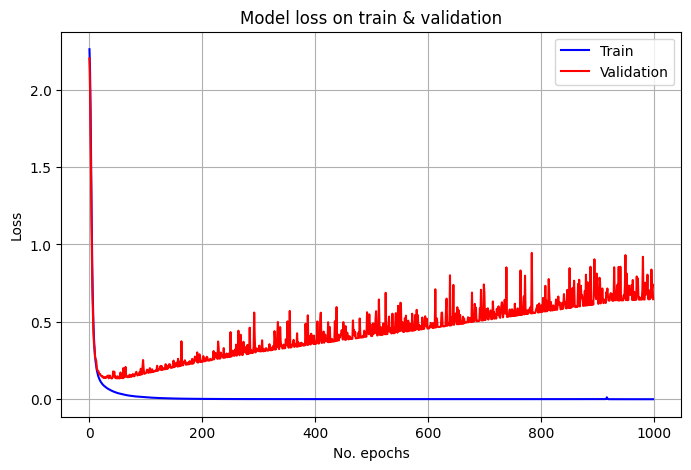

In [ ]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

# Matriz de confusión normalizada para datos de entrenamiento

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Datos de entrenamiento normalizados
x_train = df_train.iloc[:,0:64]
y_train = df_train["class"]

In [ ]:
y_train

4026    9
1548    3
1709    1
2195    2
1216    3
       ..
2009    9
1180    3
3441    9
1344    2
1289    2
Name: class, Length: 3042, dtype: int64

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
"""
Para entrenar las redes neuronales para obtener la matríz de confusión y el accuracy:

(a). 10 neuronas en la capa oculta usando función de activación ReLU y 1000 épocas (max_iter=1000) como máximo:

clf = MLPClassifier(hidden_layer_sizes=(10,1), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc1_mod = clf.fit(x_train, y_train)
y_pred_1 = clf.predict(x_train)

(b). 40 neuronas en la capa oculta usando función de activación ReLU y 1000 épocas (max_iter=1000) como máximo:

clf = MLPClassifier(hidden_layer_sizes=(40,1), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc1_mod = clf.fit(x_train, y_train)
y_pred_1 = clf.predict(x_train)

(c). 10 neuronas en la capa oculta usando función de activación Tanh y 1000 épocas (max_iter=1000) como máximo:

clf = MLPClassifier(hidden_layer_sizes=(10,1), max_iter=1000, activation = 'tanh', solver='adam', random_state=10)
prc1_mod = clf.fit(x_train, y_train)
y_pred_1 = clf.predict(x_train)

(d). 40 neuronas en la capa oculta usando función de activación Tanh y 1000 épocas (max_iter=1000) como máximo:

clf = MLPClassifier(hidden_layer_sizes=(40,1), max_iter=1000, activation = 'tanh', solver='adam', random_state=10)
prc1_mod = clf.fit(x_train, y_train)
y_pred_1 = clf.predict(x_train)

(e). 2 capas ocultas con 10 y 10 neuronas cada una y función de activación ReLU, y 1000 épocas (max_iter=1000) como máximo:

clf = MLPClassifier(hidden_layer_sizes=(10,2), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc1_mod = clf.fit(x_train, y_train)
y_pred_1 = clf.predict(x_train)

(f). 2 capas ocultas con 40 y 40 neuronas cada una y función de activación ReLU, y 1000 épocas (max_iter=1000) como máximo:

clf = MLPClassifier(hidden_layer_sizes=(40,2), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc1_mod = clf.fit(x_train, y_train)
y_pred_1 = clf.predict(x_train)

En el siguiente cuadro de código se entrena la red neuronal para obtener la matriz de confusión y el accuracy.
Para ello se deben ver los parámetros anotados en este cuadro de código

"""

"\nPara entrenar las redes neuronales para obtener la matríz de confusión y el accuracy:\n\n(a). 10 neuronas en la capa oculta usando función de activación ReLU y 1000 épocas (max_iter=1000) como máximo:\n\nclf = MLPClassifier(hidden_layer_sizes=(10,1), max_iter=1000, activation = 'relu', solver='adam', random_state=10)\nprc1_mod = clf.fit(x_train, y_train)\ny_pred_1 = clf.predict(x_train)\n\n(b). 40 neuronas en la capa oculta usando función de activación ReLU y 1000 épocas (max_iter=1000) como máximo:\n\nclf = MLPClassifier(hidden_layer_sizes=(40,1), max_iter=1000, activation = 'relu', solver='adam', random_state=10)\nprc1_mod = clf.fit(x_train, y_train)\ny_pred_1 = clf.predict(x_train)\n\n(c). 10 neuronas en la capa oculta usando función de activación Tanh y 1000 épocas (max_iter=1000) como máximo:\n\nclf = MLPClassifier(hidden_layer_sizes=(10,1), max_iter=1000, activation = 'tanh', solver='adam', random_state=10)\nprc1_mod = clf.fit(x_train, y_train)\ny_pred_1 = clf.predict(x_train)

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(40,2), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc1_mod = clf.fit(x_train, y_train)
y_pred_1 = clf.predict(x_train)

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred_1, normalize='true')

# Calcular el accuracy
accuracy = accuracy_score(y_train, y_pred_1)

print("accuracy entrenamiento: ", accuracy)

accuracy entrenamiento:  0.9986850756081526


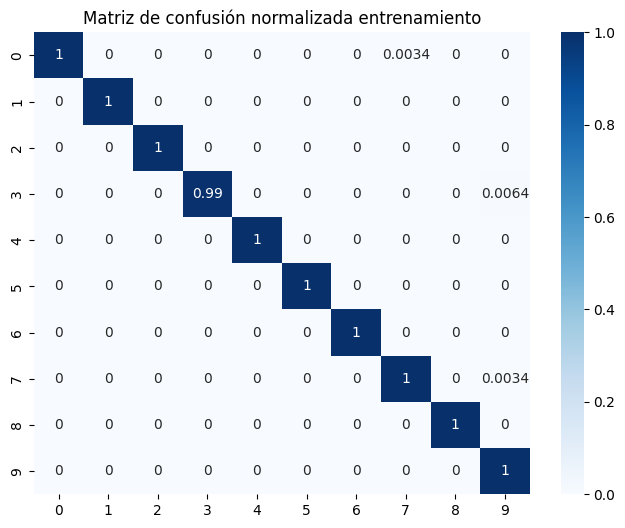

In [ ]:
# Visualizar la matriz de confusión con colores
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Matriz de confusión normalizada entrenamiento')
plt.show()

# Matriz de confusion normalizada para datos de validacion

In [ ]:
#Datos de validación normalizados
x_val = df_val.iloc[:,0:64]
y_val = df_val["class"]

In [ ]:
y_val

3459    5
4204    2
455     9
3970    5
2377    5
       ..
2020    0
1985    5
2107    7
2213    7
1236    0
Name: class, Length: 1305, dtype: int64

In [ ]:
"""
Para entrenar las redes neuronales para obtener la matríz de confusión y el accuracy:

(a). 10 neuronas en la capa oculta usando función de activación ReLU y 1000 épocas (max_iter=1000) como máximo:

clf_2 = MLPClassifier(hidden_layer_sizes=(10,1), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc2_mod = clf.fit(x_val, y_val)
y_pred_2 = clf.predict(x_val)

(b). 40 neuronas en la capa oculta usando función de activación ReLU y 1000 épocas (max_iter=1000) como máximo:

clf_2 = MLPClassifier(hidden_layer_sizes=(40,1), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc2_mod = clf.fit(x_val, y_val)
y_pred_2 = clf.predict(x_val)

(c). 10 neuronas en la capa oculta usando función de activación Tanh y 1000 épocas (max_iter=1000) como máximo:

clf_2 = MLPClassifier(hidden_layer_sizes=(10,1), max_iter=1000, activation = 'tanh', solver='adam', random_state=10)
prc2_mod = clf.fit(x_val, y_val)
y_pred_2 = clf.predict(x_val)

(d). 40 neuronas en la capa oculta usando función de activación Tanh y 1000 épocas (max_iter=1000) como máximo:

clf_2 = MLPClassifier(hidden_layer_sizes=(40,1), max_iter=1000, activation = 'tanh', solver='adam', random_state=10)
prc2_mod = clf.fit(x_val, y_val)
y_pred_2 = clf.predict(x_val)

(e). 2 capas ocultas con 10 y 10 neuronas cada una y función de activación ReLU, y 1000 épocas (max_iter=1000) como máximo:

clf_2 = MLPClassifier(hidden_layer_sizes=(10,2), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc2_mod = clf.fit(x_val, y_val)
y_pred_2 = clf.predict(x_val)

(f). 2 capas ocultas con 40 y 40 neuronas cada una y función de activación ReLU, y 1000 épocas (max_iter=1000) como máximo:

clf_2 = MLPClassifier(hidden_layer_sizes=(40,2), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc2_mod = clf.fit(x_val, y_val)
y_pred_2 = clf.predict(x_val)

En el siguiente cuadro de código se entrena la red neuronal para obtener la matriz de confusión y el accuracy.
Para ello se deben ver los parámetros anotados en este cuadro de código

"""

"\nPara entrenar las redes neuronales para obtener la matríz de confusión y el accuracy:\n\n(a). 10 neuronas en la capa oculta usando función de activación ReLU y 1000 épocas (max_iter=1000) como máximo:\n\nclf_2 = MLPClassifier(hidden_layer_sizes=(10,1), max_iter=1000, activation = 'relu', solver='adam', random_state=10)\nprc2_mod = clf.fit(x_val, y_val)\ny_pred_2 = clf.predict(x_val)\n\n(b). 40 neuronas en la capa oculta usando función de activación ReLU y 1000 épocas (max_iter=1000) como máximo:\n\nclf_2 = MLPClassifier(hidden_layer_sizes=(40,1), max_iter=1000, activation = 'relu', solver='adam', random_state=10)\nprc2_mod = clf.fit(x_val, y_val)\ny_pred_2 = clf.predict(x_val)\n\n(c). 10 neuronas en la capa oculta usando función de activación Tanh y 1000 épocas (max_iter=1000) como máximo:\n\nclf_2 = MLPClassifier(hidden_layer_sizes=(10,1), max_iter=1000, activation = 'tanh', solver='adam', random_state=10)\nprc2_mod = clf.fit(x_val, y_val)\ny_pred_2 = clf.predict(x_val)\n\n(d). 40 

In [ ]:
clf_2 = MLPClassifier(hidden_layer_sizes=(40,2), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc2_mod = clf.fit(x_val, y_val)
y_pred_2 = clf.predict(x_val)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Calcular la matriz de confusión
cm2 = confusion_matrix(y_val, y_pred_2, normalize='true')

# Calcular el accuracy
accuracy = accuracy_score(y_val, y_pred_2)

print("accuracy validación: ", accuracy)

accuracy validación:  0.9977011494252873


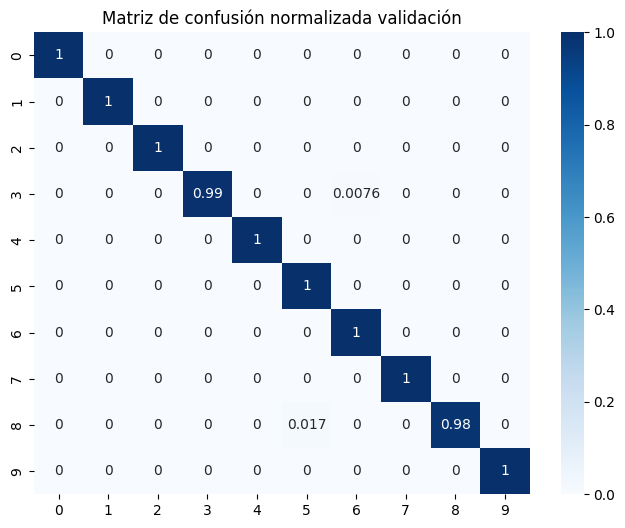

In [ ]:
# Visualizar la matriz de confusión con colores
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, cmap='Blues')
plt.title('Matriz de confusión normalizada validación')
plt.show()

## Matriz de confusión conjuntos de prueba

Se realiza en el último modelo de la red neuronal (2 capas ocultas con 40 y 40 neuronas cada una y función de activación ReLU) debido a que tiene mayor accuracy en el conjunto de validación

In [ ]:
#Datos de prueba normalizados
x_test = df_test.iloc[:,0:64]
y_test = df_test["class"]

In [ ]:
y_test

0       5
1       9
2       4
3       0
4       7
       ..
1267    9
1268    4
1269    6
1270    6
1271    7
Name: class, Length: 1272, dtype: int64

In [ ]:
clf_3 = MLPClassifier(hidden_layer_sizes=(40,2), max_iter=1000, activation = 'relu', solver='adam', random_state=10)
prc3_mod = clf.fit(x_test, y_test)
y_pred_3 = clf.predict(x_test)

In [ ]:
# Calcular la matriz de confusión
cm3 = confusion_matrix(y_test, y_pred_3, normalize='true')

# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred_3)

print("accuracy test: ", accuracy)

accuracy test:  0.9976415094339622


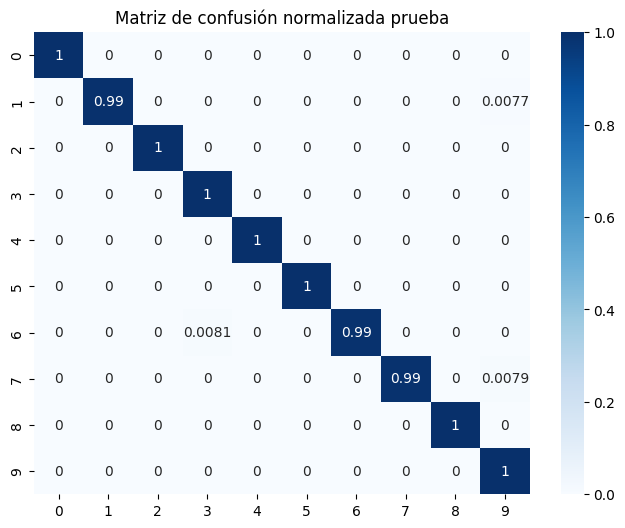

In [ ]:
# Visualizar la matriz de confusión con colores
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, cmap='Blues')
plt.title('Matriz de confusión normalizada prueba')
plt.show()